In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt


In [3]:
import numpy as np
import pandas as pd


In [4]:
import datetime as dt


# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func


In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)


In [8]:
# We can view all of the classes that automap found
Base.classes.keys()


['measurement', 'station']

In [66]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station


In [67]:
# Create our session (link) from Python to the DB
session = Session(engine)


# Exploratory Climate Analysis

In [68]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database

# Get the last date of entry
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

# Get the date 365 days from the last date.
first_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Retrieve the last 12 months of precipitation data
one_year_query = session.query(Measurement.date, Measurement.prcp).\
                        filter(Measurement.date > first_date).\
                        order_by(Measurement.date).statement


In [69]:
# Perform a query to retrieve the data and precipitation scores
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
date_prcp_df = pd.read_sql(one_year_query, engine).dropna()
date_prcp_df.head(5)


,date,prcp
0,2016-08-24,0.08
1,2016-08-24,2.15
2,2016-08-24,2.28
4,2016-08-24,1.22
5,2016-08-24,2.15


/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


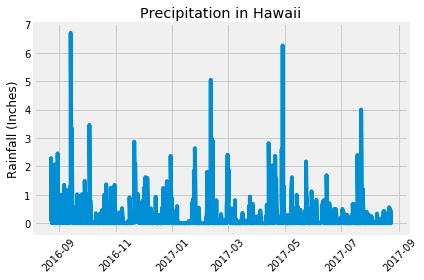

In [13]:
# Use Pandas Plotting with Matplotlib to plot the data
date_prcp_df['date']  = pd.to_datetime(date_prcp_df['date'])
plt.plot(date_prcp_df['date'], date_prcp_df['prcp'])
plt.title("Precipitation in Hawaii")
plt.xlabel('')
plt.ylabel('Rainfall (Inches)')
plt.xticks(rotation='45')
plt.tight_layout()
plt.show()


In [70]:
# Use Pandas to calculate the summary statistics for the precipitation data
date_prcp_df.describe()


,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [71]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(Station.station).count()
print("There are {} stations.".format(station_count))


There are 9 stations.


In [72]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

tobs_by_station = engine.execute('select station, count(station) from measurement group by station order by count(station) desc').fetchall()
tobs_by_station


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [73]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
min_max_avg = session.query(Measurement.station,func.min(Measurement.tobs), func.max(Measurement.tobs),func.avg(Measurement.tobs)).filter(Measurement.station == tobs_by_station[0][0]).all()
min_max_avg



[('USC00519281', 54.0, 85.0, 71.66378066378067)]

In [74]:
print(f"Most Active Station: {min_max_avg[0][0]}")
print(f"Lowest Temperature: {min_max_avg[0][1]} Fahrenheit")
print(f"Highest Temperature: {min_max_avg[0][2]} Fahrenheit")
print(f"Average Temperature: {round(min_max_avg[0][3], 2)} Fahrenheit")


Most Active Station: USC00519281
Lowest Temperature: 54.0 Fahrenheit
Highest Temperature: 85.0 Fahrenheit
Average Temperature: 71.66 Fahrenheit


In [75]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station 

most_active_station = 'USC00519281'
one_year_query_active = session.query(Measurement.date, Measurement.tobs).\
                    filter(Measurement.station == most_active_station).\
                    filter(Measurement.date > first_date).\
                    order_by(Measurement.date).statement
             
    
# Save the query results as a Pandas DataFrame and set the index to the date column
most_active_df = pd.read_sql(one_year_query_active, engine).dropna()
most_active_df.head(5)


,date,tobs
0,2016-08-24,77.0
1,2016-08-25,80.0
2,2016-08-26,80.0
3,2016-08-27,75.0
4,2016-08-28,73.0


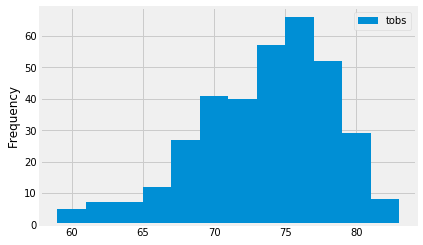

In [35]:
# Sort the dataframe by date and plot the results as a histogram
most_active_df = most_active_df.sort_index(ascending=True)
most_active_df.plot(kind='hist', bins=12)


In [76]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    
    # Docstring for the function `calc_temps`
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    # Query the minimum, average and maximum temperatures
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# Function usage example (Call on the function with the dates provided)
print(calc_temps('2012-02-28', '2012-03-05'))


[(62.0, 69.57142857142857, 74.0)]


In [78]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
HI_trip = calc_temps('2016-09-14','2016-09-20')
print(HI_trip)


[(70.0, 77.2, 81.0)]


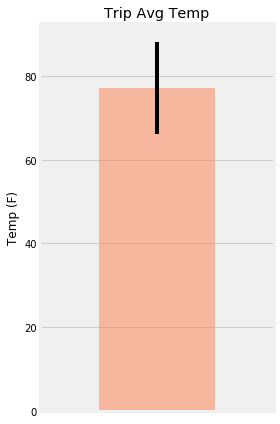

In [87]:
# Create a dataframe with the calculated tmin, tavg, and tmax values
HI_trip_temp_df = pd.DataFrame(HI_trip, columns=['tmin', 'tavg', 'tmax'])

# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (year)
HI_trip_temp_df.plot.bar(y='tavg', yerr=(HI_trip_temp_df['tmax'] - HI_trip_temp_df['tmin']), title='Trip Avg Temp', color='coral', alpha=0.5, figsize=(4,6))
plt.xticks(np.arange(1, 1.0))
plt.ylabel("Temp (F)")
plt.tight_layout()
plt.gca().legend_.remove()
plt.savefig("Images/HI_trip_temp.png")
plt.show()


In [80]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

rainfall_by_station = session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation, Measurement.prcp).\
                    filter(Measurement.station == Station.station).\
                    filter(Measurement.date >= '2015-09-14').\
                    filter(Measurement.date <= '2015-09-20').\
                    group_by(Measurement.station).\
                    order_by(Measurement.prcp.desc()).all()

print(rainfall_by_station)


[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 2.57), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.77), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.63), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.52), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.31), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, None), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, None), ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, None)]


## Optional Challenge Assignment

In [81]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")


[(62.0, 69.15384615384616, 77.0)]

In [82]:
# Calculate the daily normals for your trip
# Push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2016-09-14'
end_date ='2016-09-20'

# Use the start and end date to create a range of dates
dates = session.query(Measurement.date).\
        filter(Measurement.date >= start_date).\
        filter(Measurement.date <= end_date).\
        group_by(Measurement.date).all()


In [83]:
# List comprehension to get the elements in the tuple from the dates query 
trip_dates = [x[0] for x in dates]

# Strip off the year and save a list of %m-%d strings with another list comprehension 
trip_dates_stripped= [x[5:] for x in trip_dates]

# Find the start month/day and the end month/day 
start_month_day = trip_dates_stripped[0]
end_month_day = trip_dates_stripped[-1]


In [84]:
# daily_normals = [session.query(func.min(Measurement.tobs),func.avg(Measurement.tobs),func.max(Measurement.tobs)).
        # filter(Measurement.date >= start_date).
        # filter(Measurement.date <= end_date).
        # group_by(Measurement.date).all()]
        
# Loop through the list of %m-%d strings and calculate the normals for each date    
daily_normals = [session.query(func.min(Measurement.tobs),
                       func.avg(Measurement.tobs),
                       func.max(Measurement.tobs)).
                       filter(func.strftime("%m-%d", Measurement.date) >= start_month_day).
                       filter(func.strftime("%m-%d", Measurement.date) <= end_month_day).
                       group_by(func.strftime("%m-%d", Measurement.date)).all()]

daily_normals = daily_normals[0]
print("Aggregate Daily Normals for 09-14-2016 to 09-20-2016")
daily_normals


Aggregate Daily Normals for 09-14-2016 to 09-20-2016


[(69.0, 75.98076923076923, 85.0),
 (67.0, 76.14, 81.0),
 (70.0, 77.40384615384616, 86.0),
 (68.0, 76.57692307692308, 83.0),
 (67.0, 75.85106382978724, 84.0),
 (68.0, 76.34693877551021, 87.0),
 (69.0, 76.14583333333333, 83.0)]

In [85]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index

# Create a dataframe from the previous query 
daily_normals_df= pd.DataFrame(daily_normals,columns=['tmin', 'tavg', 'tmax'])

# Add trip_dates to Pandas DataFrame
daily_normals_df['date']= trip_dates

# Change datatype from element to datetime object on Pandas, makes x axis title to add 
daily_normals_df['date'] = pd.to_datetime(daily_normals_df['date'], format='%Y-%m-%d')

# Set index to date
daily_normals_df.set_index('date',inplace=True)

daily_normals_df


,tmin,tavg,tmax
date,,,
2016-09-14,69.0,75.980769,85.0
2016-09-15,67.0,76.140000,81.0
2016-09-16,70.0,77.403846,86.0
2016-09-17,68.0,76.576923,83.0
2016-09-18,67.0,75.851064,84.0
2016-09-19,68.0,76.346939,87.0
2016-09-20,69.0,76.145833,83.0


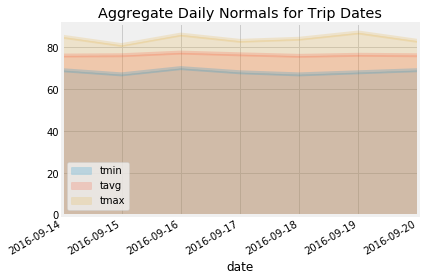

In [86]:
# Plot the daily normals as an area plot with `stacked=False`
daily_normals_df.plot(kind='area', alpha=.2, stacked=False, x_compat=True, title="Aggregate Daily Normals for Trip Dates")
plt.tight_layout()
plt.savefig("Images/DailyNormals.png")
plt.show()
